In [1]:
#importing relevant packages
from google.cloud import bigquery
from google.oauth2 import service_account
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
import pandas as pd
import numpy as np
import seaborn as sns
import folium
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import clhs as cl
%matplotlib inline

In [ ]:
#Loading geo_census data
file = 'geo_census.csv'
data = pd.read_csv(file)
data.head()

In [ ]:
data.columns

In [ ]:
data.shape

### Feature Engineering

In [ ]:
#dropping columns with _pc in their names
for column in data.columns:
    if '_pc' in column:
        data.drop(column, axis = 1, inplace = True)
data.head()

In [90]:
#Renaming some columns for better understandability
data.rename(columns = {'d': 'district', 's': 'subcounty', 'p':'parish', 'pop':'population', 'hhs':'households'}, inplace = True)
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,490.22,5813.62,1405.81,4.14,10.85,9.75,0.19,0.17,"POLYGON ((32.52529 0.33488, 32.52572 0.33540, ...",POINT(32.5133620505223 0.356148577052009)
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,35.28,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON ((32.72674 0.32632, 32.72609 0.32735, ...",POINT(32.7009147194484 0.333434596471355)
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,454.04,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON ((32.62339 0.35743, 32.62403 0.35756, ...",POINT(32.6267137789408 0.368905588996633)
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,1.67,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON ((32.63901 0.28775, 32.63904 0.28776, ...",POINT(32.6401789189264 0.298033199468685)
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,88.35,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON ((32.60767 0.35237, 32.60787 0.35211, ...",POINT(32.6181453501911 0.346662584687354)


In [91]:
#Drop rows with null values
data.dropna(axis=0, inplace=True)
data = data.reset_index(drop=True)
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,kitch_open_space_per_km,pop_density,hhs_density,pop_per_hhs,T123_per_sqkm,not_T123_per_sqkm,T123_per_person,not_T123_per_person,geometry,centroid
0,WAKISO,WAKISO,KYEBANDO,61051,14763,21.3,32.513362,0.356149,10.501383,10.412916,...,490.22,5813.62,1405.81,4.14,10.85,9.75,0.19,0.17,"POLYGON ((32.52529 0.33488, 32.52572 0.33540, ...",POINT(32.5133620505223 0.356148577052009)
1,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,35.28,605.86,136.01,4.45,3.44,3.01,0.57,0.50,"POLYGON ((32.72674 0.32632, 32.72609 0.32735, ...",POINT(32.7009147194484 0.333434596471355)
2,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,454.04,5818.23,1546.83,3.76,13.83,11.30,0.24,0.19,"POLYGON ((32.62339 0.35743, 32.62403 0.35756, ...",POINT(32.6267137789408 0.368905588996633)
3,KAMPALA,NAKAWA DIVISION,LUZIRA PRISONS,13803,1344,19.0,32.640179,0.298033,1.800534,1.784589,...,1.67,7666.06,746.45,10.27,9.14,9.14,0.12,0.12,"POLYGON ((32.63901 0.28775, 32.63904 0.28776, ...",POINT(32.6401789189264 0.298033199468685)
4,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,88.35,1951.55,503.39,3.88,15.48,12.29,0.79,0.63,"POLYGON ((32.60767 0.35237, 32.60787 0.35211, ...",POINT(32.6181453501911 0.346662584687354)


### data visualization

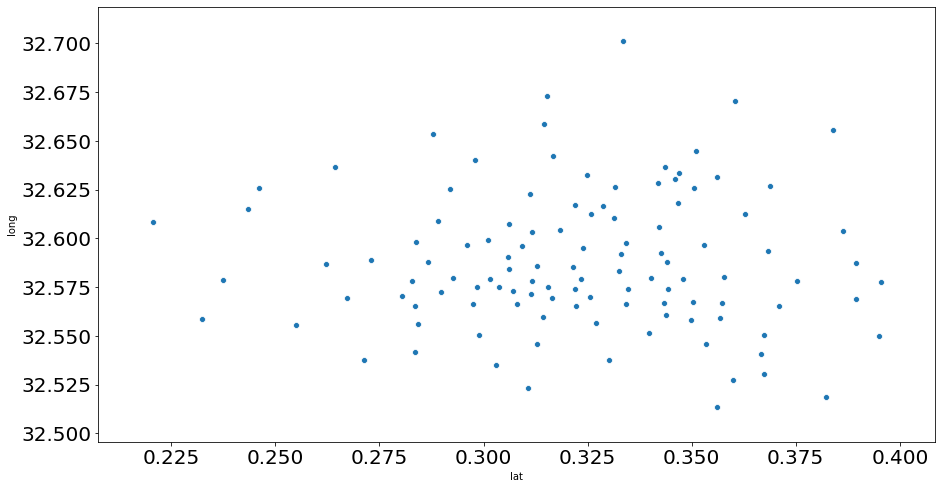

In [92]:
plt.figure(figsize = (15,8))
sns.scatterplot(data['lat'], data['long'])

In [93]:
# display coordinates on map of kampala
map_pickup = folium.Map( location=[0.3476,32.5825])
data.apply(lambda row:folium.CircleMarker(location=[row['lat'], row['long']] ).add_to(map_pickup), axis=1)
# optional: save the map.
map_pickup.save('map_pickup.html')
map_pickup

In [94]:
data.columns

Index(['district', 'subcounty', 'parish', 'population', 'households',
       'fem_hhs', 'long', 'lat', 'km2', 'area', 'perimeter', 'T123',
       'not_T123', 'light_gas_per_km', 'light_lpg_per_km',
       'light_biogas_per_km', 'light_par_lantern_per_km',
       'light_par_tadooba_per_km', 'light_candles_per_km',
       'light_firewood_per_km', 'light_cow_dung_per_km', 'light_grass_per_km',
       'cook_elec_therm_per_km', 'cook_gas_per_km', 'cook_lpg_per_km',
       'cook_biogas_per_km', 'cook_par_lantern_per_km', 'cook_charc_per_km',
       'cook_firewood_per_km', 'cook_dung_per_km', 'cook_grass_per_km',
       'waste_burn_per_km', 'kitch_outside_built_per_km',
       'kitch_make_shift_per_km', 'kitch_open_space_per_km', 'pop_density',
       'hhs_density', 'pop_per_hhs', 'T123_per_sqkm', 'not_T123_per_sqkm',
       'T123_per_person', 'not_T123_per_person', 'geometry', 'centroid'],
      dtype='object')

In [104]:
#data to be used for sampling
X = data[['light_par_tadooba_per_km', 'light_firewood_per_km', 'light_cow_dung_per_km', 'light_grass_per_km', 
          'cook_charc_per_km', 'cook_firewood_per_km', 'cook_dung_per_km', 'cook_grass_per_km', 'waste_burn_per_km',
          'kitch_outside_built_per_km', 'kitch_make_shift_per_km', 'kitch_open_space_per_km', 'pop_density', 
          'hhs_density', 'T123_per_sqkm']]
X.head()

,light_par_tadooba_per_km,light_firewood_per_km,light_cow_dung_per_km,light_grass_per_km,cook_charc_per_km,cook_firewood_per_km,cook_dung_per_km,cook_grass_per_km,waste_burn_per_km,kitch_outside_built_per_km,kitch_make_shift_per_km,kitch_open_space_per_km,pop_density,hhs_density,T123_per_sqkm
0,92.37,2.09,0.00,0.10,1220.60,89.99,0.1,0.0,1001.49,509.36,74.56,490.22,5813.62,1405.81,10.85
1,11.66,0.19,0.00,0.05,95.64,25.93,0.0,0.0,79.32,55.84,11.66,35.28,605.86,136.01,3.44
2,33.02,2.06,0.00,0.00,1069.40,52.97,0.0,0.0,324.71,345.00,46.78,454.04,5818.23,1546.83,13.83
3,0.56,0.00,0.00,0.00,58.32,1.11,0.0,0.0,203.83,157.18,2.78,1.67,7666.06,746.45,9.14
4,1.11,0.00,0.37,0.00,289.19,12.25,0.0,0.0,109.88,46.03,13.36,88.35,1951.55,503.39,15.48


In [96]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 15 columns):
light_par_tadooba_per_km      114 non-null float64
light_firewood_per_km         114 non-null float64
light_cow_dung_per_km         114 non-null float64
light_grass_per_km            114 non-null float64
cook_charc_per_km             114 non-null float64
cook_firewood_per_km          114 non-null float64
cook_dung_per_km              114 non-null float64
cook_grass_per_km             114 non-null float64
waste_burn_per_km             114 non-null float64
kitch_outside_built_per_km    114 non-null float64
kitch_make_shift_per_km       114 non-null float64
kitch_open_space_per_km       114 non-null float64
pop_density                   114 non-null float64
hhs_density                   114 non-null float64
T123_per_sqkm                 114 non-null float64
dtypes: float64(15)
memory usage: 13.5 KB


### Conditional Latin Hypercube Sampling

In [97]:
#carrying out cLHS
sample_number=40
# cLHS
sampled = cl.clhs(X, sample_number, max_iterations=1000)

cLHS:100%|███████████████████████████████████████████|1000/1000 [Elapsed time: 1.599722146987915, ETA: 0.0, 625.11it/s]


In [98]:
clhs_sample = data.iloc[sampled["sample_indices"]]
clhs_sample.shape

(40, 44)

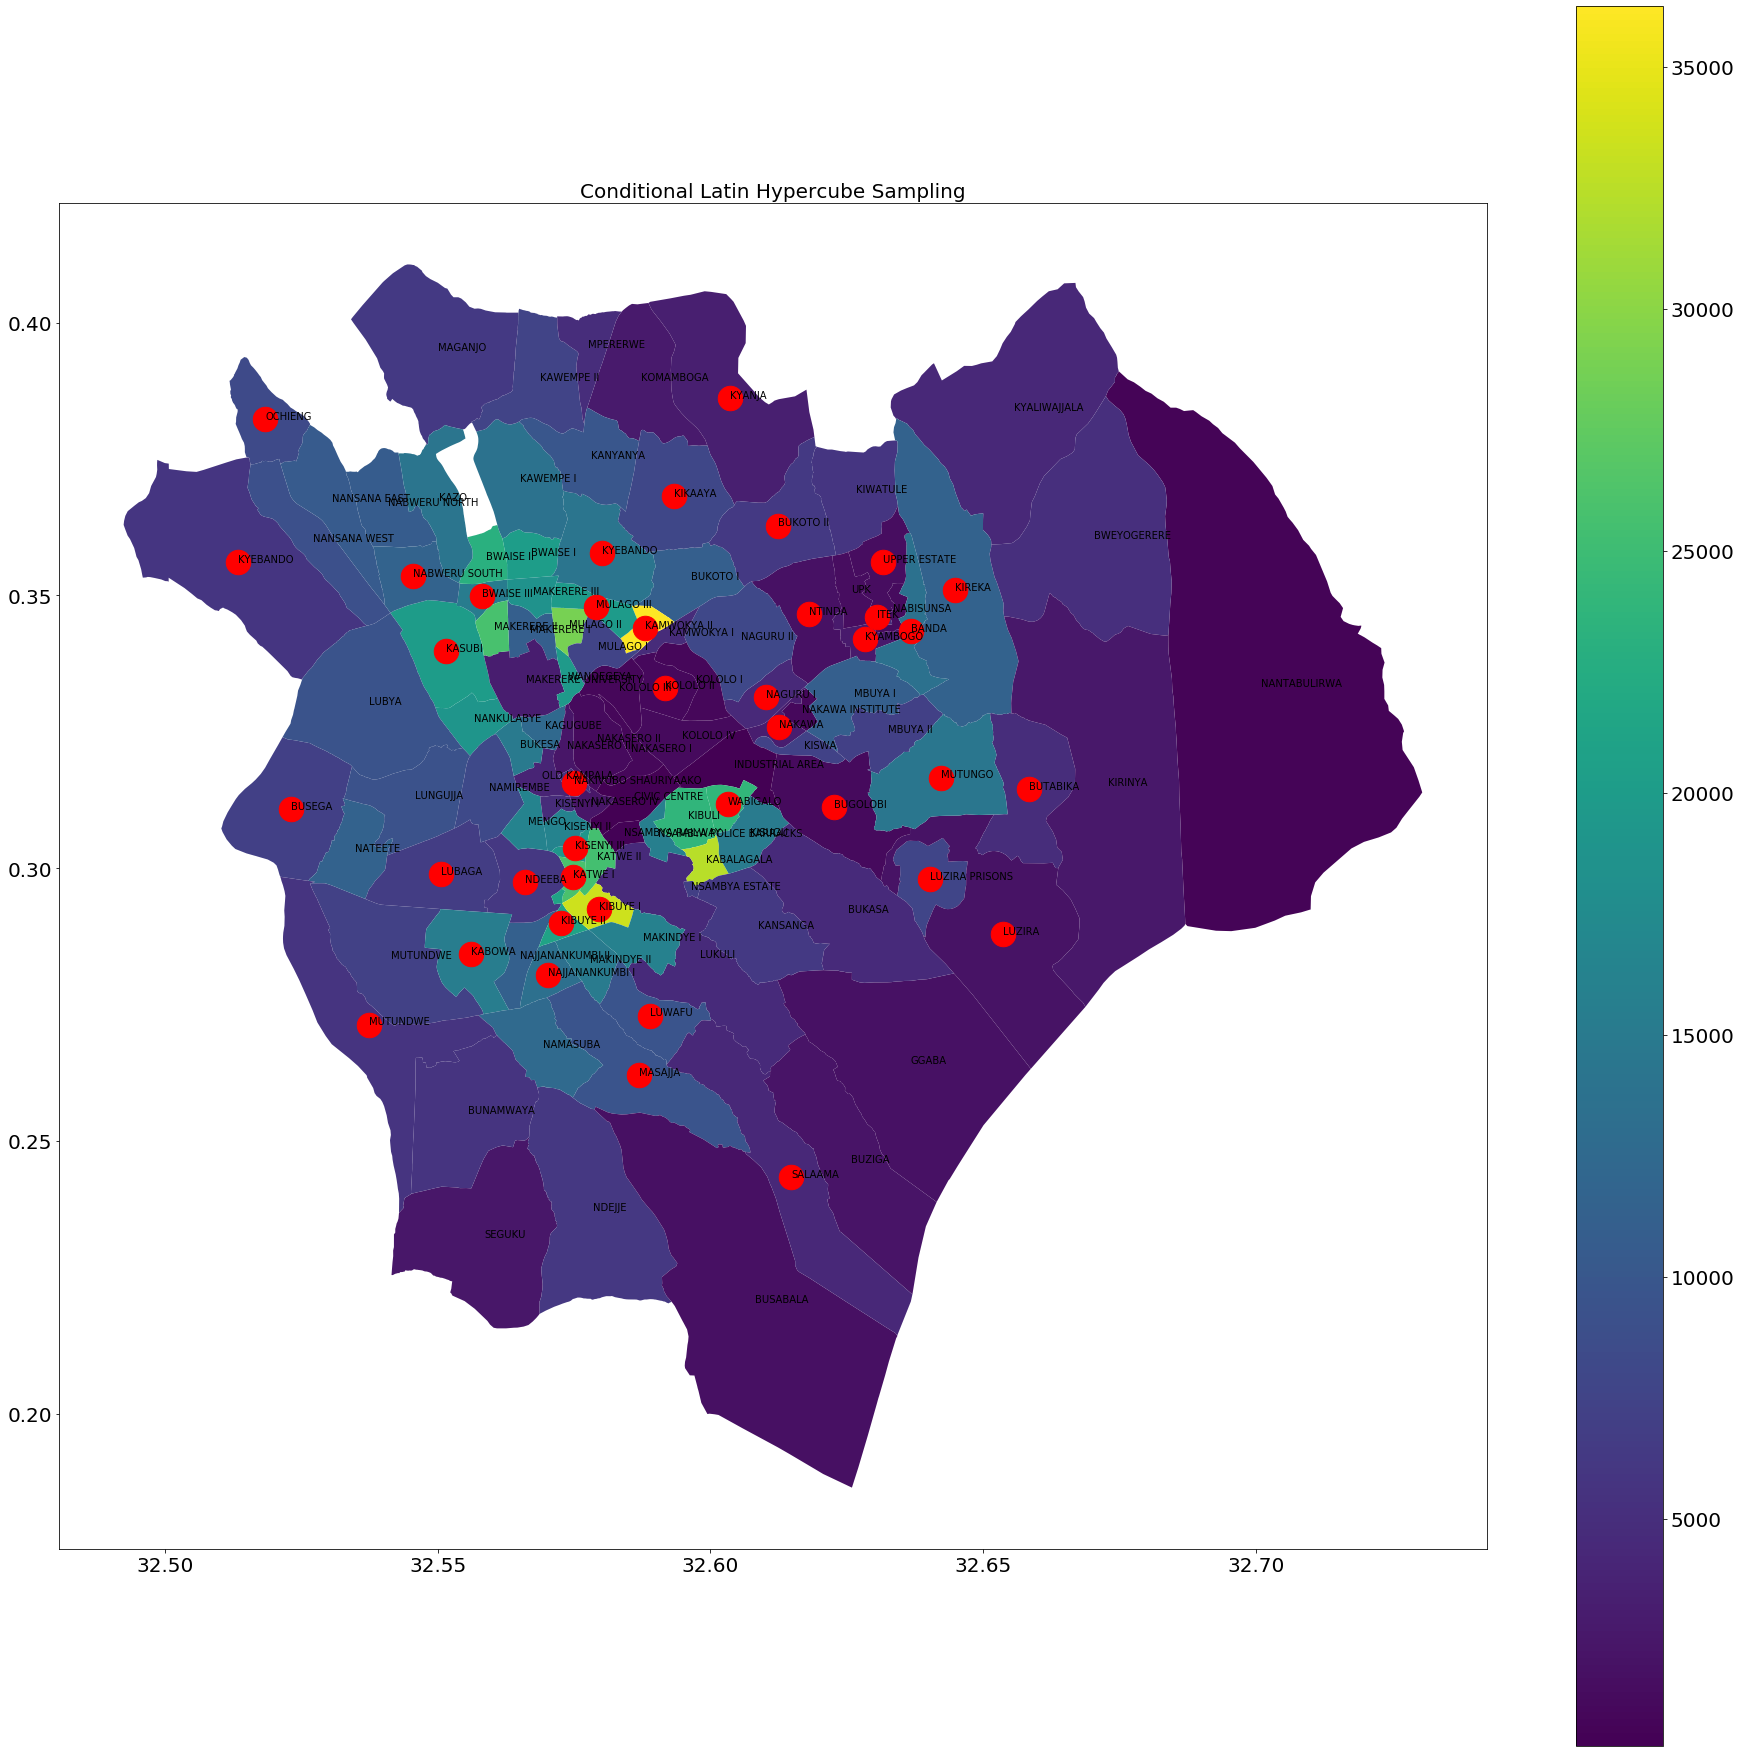

In [99]:
fig, ax = plt.subplots(figsize=(32, 32))
chart_title =  'Conditional Latin Hypercube Sampling' 
plt.title(chart_title,fontsize=20)
ax.set_aspect('equal')
data.plot(column='pop_density', ax=ax, legend=True)
for i, txt in enumerate(data.parish):
    ax.annotate(txt, (data.long[i], data.lat[i]))
#plt.scatter(data.long, data.lat, s=600, c='k')
plt.scatter(clhs_sample.long, clhs_sample.lat, s=600, c='r')
plt.show()
#fig.savefig('First Sensor Locations.png')

In [103]:
clhs_sample['parish'].tolist()

['BUKOTO II',
 'NTINDA',
 'KASUBI',
 'NDEEBA',
 'OCHIENG',
 'LUBAGA',
 'MUTUNDWE',
 'BUGOLOBI',
 'KIKAAYA',
 'NAKAWA',
 'LUZIRA',
 'UPPER ESTATE',
 'KAMWOKYA II',
 'KYEBANDO',
 'NABWERU SOUTH',
 'MUTUNGO',
 'KIBUYE I',
 'BWAISE III',
 'NAJJANANKUMBI I',
 'SALAAMA',
 'KISENYI III',
 'BANDA',
 'KATWE I',
 'KYEBANDO',
 'BUSEGA',
 'KOLOLO II',
 'KYAMBOGO',
 'KIBUYE II',
 'MASAJJA',
 'NAKIVUBO SHAURIYAAKO',
 'NAGURU I',
 'LUZIRA PRISONS',
 'MULAGO III',
 'LUWAFU',
 'KIREKA',
 'KYANJA',
 'BUTABIKA',
 'KABOWA',
 'ITEK',
 'WABIGALO']